<a href="https://colab.research.google.com/github/Frederick-Stein/Data-Science-Playground/blob/main/Recommendation_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
## get data
column_names = ['user_id', 'item_id', 'rating', 'timestamp']

url1 = 'https://raw.githubusercontent.com/Frederick-Stein/Data-Science-Playground/refs/heads/main/Projects/Recommendation_System/file.tsv'
utl2 = 'https://raw.githubusercontent.com/Frederick-Stein/Data-Science-Playground/refs/heads/main/Projects/Recommendation_System/Movie_Id_Titles.csv'
df = pd.read_csv(url1, sep='\t', names=column_names)
movie = pd.read_csv(utl2)
data = pd.merge(df, movie, on='item_id')
data.head()

,user_id,item_id,rating,timestamp,title
0,0,50,5,881250949,Star Wars (1977)
1,0,172,5,881250949,"Empire Strikes Back, The (1980)"
2,0,133,1,881250949,Gone with the Wind (1939)
3,196,242,3,881250949,Kolya (1996)
4,186,302,3,891717742,L.A. Confidential (1997)


In [8]:
## EDA
# data = data.drop(['timestamp', 'item_id'], axis=1)
print(data.shape)
data.info()

(100003, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100003 entries, 0 to 100002
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    100003 non-null  int64 
 1   item_id    100003 non-null  int64 
 2   rating     100003 non-null  int64 
 3   timestamp  100003 non-null  int64 
 4   title      100003 non-null  object
dtypes: int64(4), object(1)
memory usage: 3.8+ MB


                                     title  rating  num
30                    Aiqing wansui (1994)     5.0    1
1277             Santa with Muscles (1996)     5.0    2
1273  Saint of Fort Washington, The (1993)     5.0    2
1472        They Made Me a Criminal (1939)     5.0    1
1172                    Prefontaine (1997)     5.0    3
                          title  rating  num
1398           Star Wars (1977)    4.36  584
333              Contact (1997)    3.80  509
498                Fargo (1996)    4.16  508
1234  Return of the Jedi (1983)    4.01  507
860            Liar Liar (1997)    3.16  485


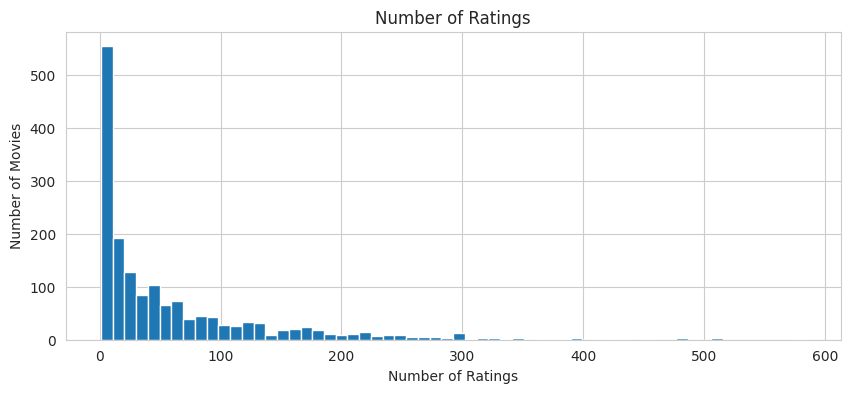

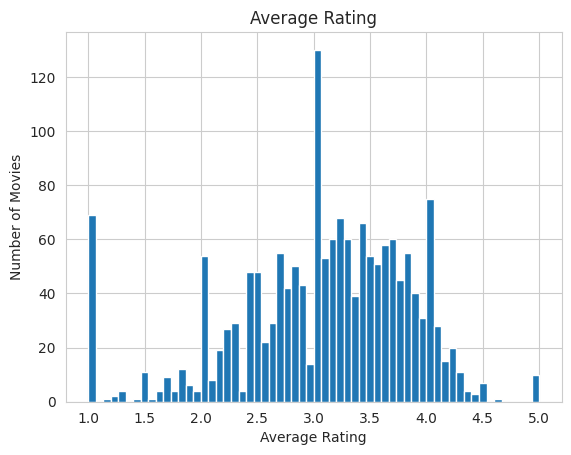

In [9]:
# prepare data
ratings = data.groupby('title').agg(
    rating = ('rating', lambda x: x.mean().round(2)),
    num = ('rating',  'count')
).reset_index()
print(ratings.sort_values('rating', ascending =False).head())
print(ratings.sort_values('num', ascending =False).head())

# visulaization
sns.set_style('whitegrid')
plt.figure(figsize = (10,4))
ratings['num'].hist(bins = 60)
plt.title('Number of Ratings')
plt.xlabel('Number of Ratings')
plt.ylabel('Number of Movies')
plt.show()
plt.title('Average Rating')
plt.xlabel('Average Rating')
plt.ylabel('Number of Movies')
ratings['rating'].hist(bins = 60)
plt.show()

In [10]:
# matrix of movie
moviemat = data.pivot_table(index='user_id', columns='title', values='rating')
moviemat.head()

title,'Til There Was You (1997),1-900 (1994),101 Dalmatians (1996),12 Angry Men (1957),187 (1997),2 Days in the Valley (1996),"20,000 Leagues Under the Sea (1954)",2001: A Space Odyssey (1968),3 Ninjas: High Noon At Mega Mountain (1998),"39 Steps, The (1935)",...,Yankee Zulu (1994),Year of the Horse (1997),You So Crazy (1994),Young Frankenstein (1974),Young Guns (1988),Young Guns II (1990),"Young Poisoner's Handbook, The (1995)",Zeus and Roxanne (1997),unknown,Á köldum klaka (Cold Fever) (1994)
user_id,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,2.0,5.0,NaN,NaN,3.0,4.0,NaN,NaN,...,NaN,NaN,NaN,5.0,3.0,NaN,NaN,NaN,4.0,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
# compute corrlation
def corr_with(R, target_col, min_overlap=5):
    t = R[target_col]
    mask = t.notna()     # users who rated target
    Rsub = R.loc[mask]
    tsub = t[mask]

    # keep items with enough co-raters in this overlap
    valid = Rsub.notna().sum(axis=0) >= min_overlap
    Rsub = Rsub.loc[:, valid]

    # drop items whose ratings are constant in the overlap (std = 0)
    nzstd = Rsub.std(skipna=True) > 0
    Rsub = Rsub.loc[:, nzstd]

    # compute Pearson correlations
    corr = Rsub.corrwith(tsub).dropna().to_frame('Correlation')

    return corr.sort_values('Correlation', ascending=False)

corr_starwars = corr_with(moviemat, "Star Wars (1977)", min_overlap=20)
corr_starwars = corr_starwars.merge(ratings, on='title', how = 'left')
corr_starwars[corr_starwars['num'] > 100].head(10)

,title,Correlation,rating,num
0,Star Wars (1977),1.000000,4.36,584
1,"Empire Strikes Back, The (1980)",0.748353,4.21,368
2,Return of the Jedi (1983),0.672556,4.01,507
5,Raiders of the Lost Ark (1981),0.536117,4.25,420
23,Austin Powers: International Man of Mystery (1...,0.377433,3.25,130
26,"Sting, The (1973)",0.367538,4.06,241
30,Indiana Jones and the Last Crusade (1989),0.350107,3.93,331
31,Pinocchio (1940),0.347868,3.67,101
40,"Frighteners, The (1996)",0.332729,3.23,115
43,L.A. Confidential (1997),0.319065,4.16,297
